<h1>Loading relevant python libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

import seaborn as sns
sns.set(style="ticks")

<h3> Versions of python/keras used in the project

In [2]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.0.9


In [3]:
import sys
print(sys.version)

2.7.14 |Anaconda, Inc.| (default, Oct 16 2017, 17:29:19) 
[GCC 7.2.0]


<h3> Loading the sample data frame

In [4]:
df = pd.read_excel('Harrow_NO2_timeseries.xls.xls')
df['measurementdategmt'] = pd.to_datetime(df['measurementdategmt'])

In [5]:
df = df.sort_values('measurementdategmt')

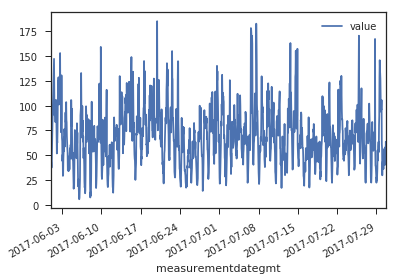

In [6]:
df.plot(x = 'measurementdategmt', y = 'value')


In [7]:
len(df)

1418

## Time series forecast test drive

In [8]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epochs, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
	
	hist = model.fit(X, y, nb_epoch=nb_epochs, batch_size=batch_size, verbose=0, shuffle=False, validation_split=0.33)

	return model, hist
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 


In [9]:
# load dataset
series = df['value'][0:1400] 

In [10]:
# transform data to be stationary
raw_values = series.values

In [11]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(raw_values, 4)
supervised_values = supervised.values

In [12]:
# split data into train and test-sets
train, test = supervised_values[0:-1200], supervised_values[-200:]

In [13]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [14]:
# fit the model
lstm_model, hist = fit_lstm(train_scaled, 1, 60, 4)

/opt/anaconda2/lib/python2.7/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [15]:
hist.history['loss']

[0.26780935641589609, 0.23698739695477702, 0.22299306211061776]

In [16]:
df1= pd.DataFrame(np.array(hist.history['loss']), columns = ['loss'])

In [17]:
df1

,loss
0,0.267809
1,0.236987
2,0.222993


In [18]:
# serialize model to JSON
model_json = lstm_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights("model.h5")

In [19]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	print(X)
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	#yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

[-0.42184434 -0.09483322 -0.36298234 -0.09090909]
Month=1, Predicted=87.256898, Expected=88.400000
[-0.3145847  -0.42184434 -0.09483322 -0.36298234]
Month=2, Predicted=88.050684, Expected=103.500000
[-0.27141923 -0.3145847  -0.42184434 -0.09483322]
Month=3, Predicted=86.029472, Expected=85.700000
[-0.3263571  -0.27141923 -0.3145847  -0.42184434]
Month=4, Predicted=86.836073, Expected=83.200000
[-0.24133421 -0.3263571  -0.27141923 -0.3145847 ]
Month=5, Predicted=86.601930, Expected=69.100000
[-0.13930674 -0.24133421 -0.3263571  -0.27141923]
Month=6, Predicted=85.963219, Expected=62.500000
[-0.29758012 -0.13930674 -0.24133421 -0.3263571 ]
Month=7, Predicted=86.270330, Expected=56.800000
[-0.18116416 -0.29758012 -0.13930674 -0.24133421]
Month=8, Predicted=86.148837, Expected=52.900000
[-0.17854807 -0.18116416 -0.29758012 -0.13930674]
Month=9, Predicted=85.067179, Expected=35.100000
[-0.26095487 -0.17854807 -0.18116416 -0.29758012]
Month=10, Predicted=85.906843, Expected=39.100000
[-0.2517

Test RMSE: 34.041


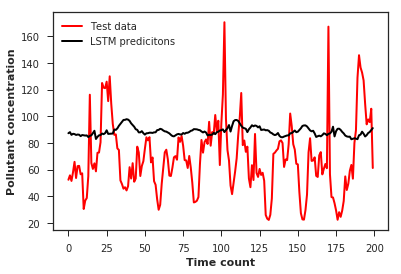

In [20]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-200:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-200:], '-r', label = 'Test data', linewidth = 2)
pyplot.plot(predictions, '-k', label = 'LSTM predicitons', linewidth = 2)
pyplot.legend()
pyplot.xlabel('Time count', fontweight = 'bold')
pyplot.ylabel('Pollutant concentration', fontweight = 'bold')
pyplot.show()



In [21]:
from sklearn.metrics import r2_score

In [22]:
r2_score(raw_values[-200:], predictions)

-0.62703711785332361